In [1]:
import yfinance as yf


tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start="2015-01-01", end="2024-01-01")['Adj Close']

# Inspect the data
print(data.head())
print(data.tail())
print(data.info())
print(data.describe())


[*********************100%%**********************]  2 of 2 completed

Ticker           AAPL       MSFT
Date                            
2015-01-02  24.373953  40.232849
2015-01-05  23.687304  39.862881
2015-01-06  23.689529  39.277813
2015-01-07  24.021711  39.776836
2015-01-08  24.944687  40.946991
Ticker            AAPL        MSFT
Date                              
2023-12-22  192.868134  372.543915
2023-12-26  192.320221  372.623505
2023-12-27  192.419830  372.036713
2023-12-28  192.848221  373.240112
2023-12-29  191.802185  373.995972
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2264 non-null   float64
 1   MSFT    2264 non-null   float64
dtypes: float64(2)
memory usage: 53.1 KB
None
Ticker         AAPL         MSFT
count   2264.000000  2264.000000
mean      81.852794   155.968317
std       56.305992   100.594591
min       20.720036    34.760635
25%       32.999371    59.738401
50%     

In [3]:
missing_values = data.isnull().sum()
print(missing_values)

Ticker
AAPL    0
MSFT    0
dtype: int64


In [5]:
### Cointegration Analysis
# Perform cointegration tests to identify pairs of assets that have a long-term equilibrium relationship. Cointegration means that despite short-term deviations, the assets tend to move together in the long run.

In [6]:
from statsmodels.tsa.stattools import coint
import numpy as np

# Perform the cointegration test between two assets
stock_A = data['AAPL']
stock_B = data['MSFT']

coint_score, p_value, _ = coint(stock_A, stock_B)

# Check if the p-value is less than 0.05 (i.e., 5% significance level)
if p_value < 0.05:
    print("Cointegration found!")
else:
    print("No cointegration found")


No cointegration found


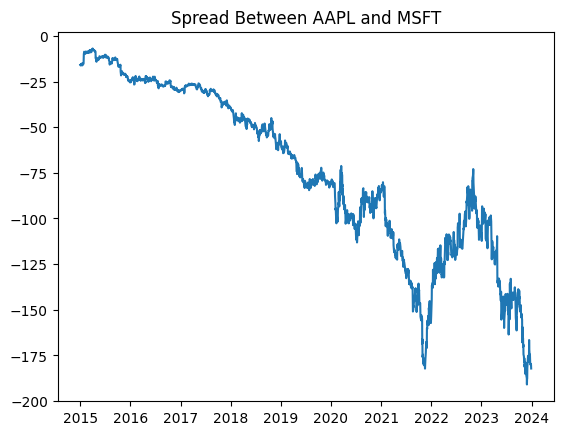

In [7]:
### create a spread between pairs
# Calculate the spread as the difference between the two stock prices
spread = stock_A - stock_B

# Plot the spread to visualize
import matplotlib.pyplot as plt

plt.plot(spread)
plt.title('Spread Between AAPL and MSFT')
plt.show()


In [11]:

window = 10  # 10-day rolling window
spread_mean = spread.rolling(window=window).mean()
spread_std = spread.rolling(window=window).std()

# Create the ratio between stock_A and stock_B as a feature
ratio = stock_A / stock_B

# Create a feature matrix (e.g., spread, spread_mean, spread_std, ratio)
X = np.column_stack((spread, spread_mean, spread_std, ratio))

# Create the target variable (1 for mean reversion, 0 for divergence)
y = (spread.shift(-1) < spread).astype(int)  # Example target


In [12]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.4900662251655629


In [13]:
initial_investment = 10000  #  initial capital
capital = initial_investment
positions = []

for i in range(len(y_test)):
    # Check if the model predicts reversion
    if y_pred[i] == 1:
        # Go long on stock_B and short on stock_A (if the spread is positive)
        positions.append(('long', 'B', X_test[i]))
        positions.append(('short', 'A', X_test[i]))
    else:
        # Hold or exit positions
        continue




In [14]:
alculating the Sharpe ratio
returns = np.diff(spread) / spread[:-1]  # Simplified returns based on spread

sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized Sharpe ratio
print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: 0.8038652186199324
